In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB  # naive bayes
from sklearn.neighbors import KNeighborsClassifier #kNN
from sklearn.svm import SVC  # support vector machine
filename = '../data/cleaned/casearrest_cl.csv'
filename2= '../data/cleaned/compas_failure_cl.csv'
filename3= '../data/cleaned/jailhistory_cl.csv'
filename4= '../data/original/people_charge.csv'
filename5= '../data/cleaned/people_cl.csv'
filename6= '../data/cleaned/prisonhistory_cl.csv'
filename7= '../data/cleaned/compas_recid_cl.csv'
filename8= '../data/cleaned/compas_violence_cl.csv'
casearrest = pd.read_csv(filename)
print("casearrest size:      ", casearrest.shape)
compas_failure=pd.read_csv(filename2)
print("compas_failure size:  ", compas_failure.shape)
jailhistory=pd.read_csv(filename3)
print("jailhistory size:     ", jailhistory.shape)
people_charge=pd.read_csv(filename4)
print("people_charge size:   ", people_charge.shape)
people=pd.read_csv(filename5)
print("people size:          ", people.shape)
prisonhistory=pd.read_csv(filename6)
print("prisonhistory size:   ", prisonhistory.shape)
compas_recid=pd.read_csv(filename7)
print("compas_recid size:    ", compas_recid.shape)
compas_violence=pd.read_csv(filename8)
print("compas_violence size: ", compas_violence.shape)

casearrest size:       (128183, 7)
compas_failure size:   (12526, 14)
jailhistory size:      (22111, 8)
people_charge size:    (148086, 17)
people size:           (10996, 27)
prisonhistory size:    (4945, 8)
compas_recid size:     (12526, 14)
compas_violence size:  (12526, 14)


In [4]:
"""cargostotales=people_charge['charge_degree'].to_numpy()
tipos_dec_cargo=np.unique(cargostotales)
print(tipos_dec_cargo)
switcher={
    '(0)':1,
    '(CO3)':1,
    '(NI0)':1,
    '(CT)':1,
    '(MO3)':1,
    '(M3)':1,
    '(M2)':1,
    '(M1)':1,
    '(TC4)':1,
    '(TCX)':1,
    '(F7)':1,
    '(F6)':1,
    '(F5)':1,
    '(F3)':1,
    '(F2)':1,
    '(F1)':1,
}"""

"cargostotales=people_charge['charge_degree'].to_numpy()\ntipos_dec_cargo=np.unique(cargostotales)\nprint(tipos_dec_cargo)\nswitcher={\n    '(0)':1,\n    '(CO3)':1,\n    '(NI0)':1,\n    '(CT)':1,\n    '(MO3)':1,\n    '(M3)':1,\n    '(M2)':1,\n    '(M1)':1,\n    '(TC4)':1,\n    '(TCX)':1,\n    '(F7)':1,\n    '(F6)':1,\n    '(F5)':1,\n    '(F3)':1,\n    '(F2)':1,\n    '(F1)':1,\n}"

Queremos ver como si se puede predecir la recidividad, para eso necesitaremos la tabla "people" hasta la columna "is_recid"

In [5]:
people[people.columns[1:-9]].head()

,sex,race,dob,age,juv_fel_count,juv_misd_count,juv_other_count,compas_screening_date,decile_score,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_days_from_compas,c_offense_date,c_charge_degree,is_recid
0,Male,Other,0.27451,69,0,0,0,0.93632,1,0,-1,0.93629,0.93632,1,0.93629,(F3),0
1,Male,African-American,0.62141,34,0,0,0,0.93088,3,0,-1,0.93085,0.93113,1,0.93085,(F3),1
2,Male,African-American,0.71427,24,0,0,1,0.93299,4,4,-1,0.93296,0.93299,1,0.93296,(F3),1
3,Male,African-American,0.73115,23,0,1,0,0.93050,8,1,0,0.93050,0.93050,1,0.93047,(F3),0
4,Male,Other,0.53161,43,0,0,0,0.93247,1,2,0,0.93247,0.93247,76,0.93039,(F7),0


In [6]:
dataset = people[people.columns[1:-9]].drop(columns=["age", "race", "c_charge_degree","c_offense_date"])
dataset['sex'] = np.where(dataset['sex']=='Male',1,0)


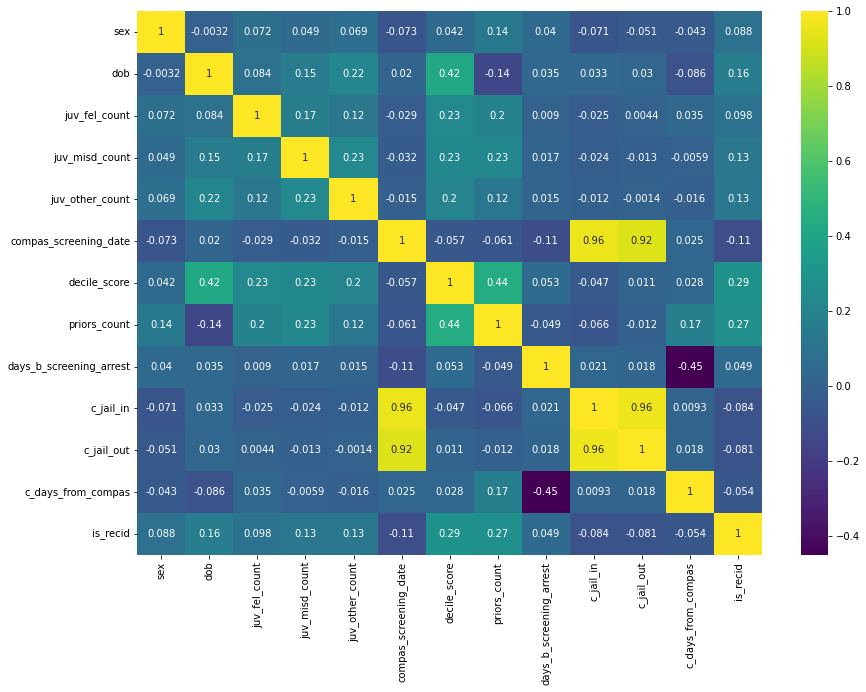

In [7]:
norm_dataset = (dataset -dataset.min())/(dataset.max() -dataset.min())
plt.figure(figsize=(14, 10))
sns.heatmap(norm_dataset.corr(method='spearman'), cmap='viridis', annot=True);

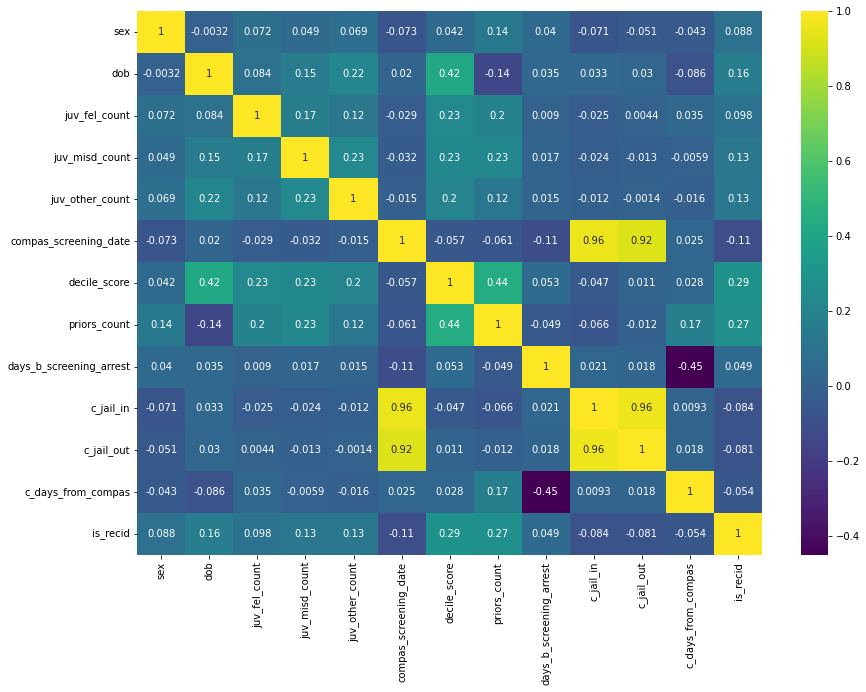

In [8]:
plt.figure(figsize=(14, 10))
sns.heatmap(dataset.corr(method='spearman'), cmap='viridis', annot=True);

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

###separamos valores
data_train, data_test, y_train, y_test = train_test_split(norm_dataset, norm_dataset['is_recid'], test_size=.30,
                                                    random_state=15, stratify=norm_dataset['is_recid'])
##subsampleamos
data_train = data_train.reset_index(drop=True)
idx = np.random.choice(data_train.loc[data_train.is_recid == 0].index, size=2545, replace=False)
data_subsampled = data_train.drop(data_train.iloc[idx].index)
##Oversamplemaos
idx = np.random.choice(data_train[data_train['is_recid'] == 1].index, size=2545)
data_oversampled = data_train.drop(data_train.iloc[idx].index)

In [10]:
### dejamos los datos para trabajar
y_test = data_test.is_recid
X_test = data_test.drop(columns=['is_recid'])
y_orig =data_train.is_recid
X_orig = data_train.drop(columns=['is_recid'])
y_subs=data_subsampled.is_recid
X_subs=data_subsampled.drop(columns=['is_recid'])
y_over=data_oversampled.is_recid
X_over=data_oversampled.drop(columns=['is_recid'])

In [11]:
#Configure tuned_parameters
tuned_parameters = {'n_neighbors': [1, 3, 5, 10],
                    'weights': ['uniform','distance']}
score = 'f1'

### modelo del original
clf_org = GridSearchCV(KNeighborsClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" ORIG Mejor combinación de parámetros:")
clf_org.fit(X_orig,y_orig)
print(clf_org.best_params_)

y_pred = clf_org.predict(X_test)

print(classification_report(y_test, y_pred))
### modelo subsampling
clf_sub = GridSearchCV(KNeighborsClassifier(),
                   param_grid=tuned_parameters,
                   cv=5,
                   scoring=score)
print(" SUB Mejor combinación de parámetros:")
clf_sub.fit(X_subs,y_subs)
print(clf_sub.best_params_)

y_pred = clf_sub.predict(X_test)

print(classification_report(y_test, y_pred))
### modelo oversampling
clf_over = GridSearchCV(KNeighborsClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" OVER Mejor combinación de parámetros:")
clf_over.fit(X_over,y_over)
print(clf_over.best_params_)

y_pred = clf_over.predict(X_test)

print(classification_report(y_test, y_pred))

 ORIG Mejor combinación de parámetros:
{'n_neighbors': 10, 'weights': 'distance'}
              precision    recall  f1-score   support

         0.0       0.73      0.83      0.78      2195
         1.0       0.54      0.39      0.45      1104

    accuracy                           0.69      3299
   macro avg       0.64      0.61      0.62      3299
weighted avg       0.67      0.69      0.67      3299

 SUB Mejor combinación de parámetros:
{'n_neighbors': 10, 'weights': 'distance'}
              precision    recall  f1-score   support

         0.0       0.77      0.62      0.69      2195
         1.0       0.46      0.64      0.53      1104

    accuracy                           0.63      3299
   macro avg       0.62      0.63      0.61      3299
weighted avg       0.67      0.63      0.64      3299

 OVER Mejor combinación de parámetros:
{'n_neighbors': 1, 'weights': 'uniform'}
              precision    recall  f1-score   support

         0.0       0.70      0.89      0.78     

In [21]:
peoplemejor=people.copy()
peoplemejor['race'] = np.where(peoplemejor['race']=='African-American',1,0)
peoplemejor['sex'] = np.where(peoplemejor['sex']=='Male',1,0)
peoplemejor = peoplemejor[peoplemejor.columns[1:-9]].drop(columns=["age", "c_charge_degree","c_offense_date"])

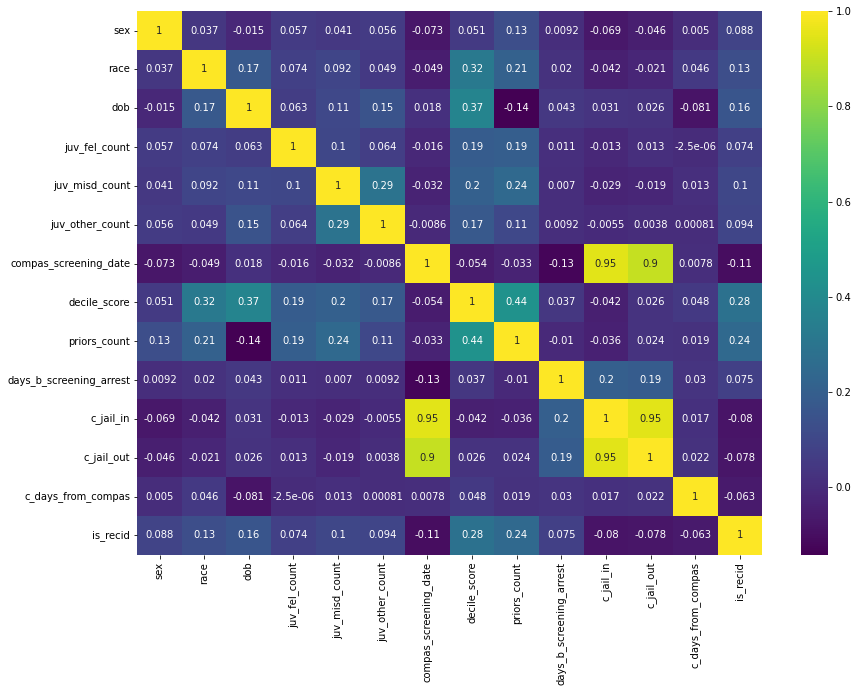

In [22]:
plt.figure(figsize=(14, 10))
sns.heatmap(peoplemejor.corr(), cmap='viridis', annot=True);

In [23]:
##########################  KNeighbors con raza
###separamos valores
X_train, X_test, y_train, y_test = train_test_split(peoplemejor, peoplemejor['is_recid'], test_size=.30,
                                                          random_state=15, stratify=peoplemejor['is_recid'])
##subsampleamos
X_train = X_train.reset_index(drop=True)
idx = np.random.choice(X_train.loc[X_train.is_recid == 0].index, size=2545, replace=False)
data_subsampled = X_train.drop(X_train.iloc[idx].index)
##Oversamplemaos
idx = np.random.choice(X_train[X_train['is_recid'] == 1].index, size=2545)
data_oversampled = X_train.drop(X_train.iloc[idx].index)
### dejamos los datos para trabajar
y_test = X_test.is_recid
X_test = X_test.drop(columns=['is_recid'])
y_orig =X_train.is_recid
X_orig = X_train.drop(columns=['is_recid'])
y_subs=data_subsampled.is_recid
X_subs=data_subsampled.drop(columns=['is_recid'])
y_over=data_oversampled.is_recid
X_over=data_oversampled.drop(columns=['is_recid'])

#Configure tuned_parameters
tuned_parameters = {'n_neighbors': [1, 3, 5, 10],
                    'weights': ['uniform','distance']}
score = 'f1'

### modelo del original
clf_org = GridSearchCV(KNeighborsClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" ORG Mejor combinación de parámetros:")
clf_org.fit(X_orig,y_orig)
print(clf_org.best_params_)

y_pred = clf_org.predict(X_test)

print(classification_report(y_test, y_pred))
### modelo subsampling
clf_sub = GridSearchCV(KNeighborsClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" SUB Mejor combinación de parámetros:")
clf_sub.fit(X_subs,y_subs)
print(clf_sub.best_params_)

y_pred = clf_sub.predict(X_test)

print(classification_report(y_test, y_pred))
### modelo oversampling
clf_over = GridSearchCV(KNeighborsClassifier(),
                        param_grid=tuned_parameters,
                        cv=5,
                        scoring=score)
print(" OVER Mejor combinación de parámetros:")
clf_over.fit(X_over,y_over)
print(clf_over.best_params_)

y_pred = clf_over.predict(X_test)

print(classification_report(y_test, y_pred))

 ORG Mejor combinación de parámetros:
{'n_neighbors': 10, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.72      0.81      0.77      2195
           1       0.51      0.38      0.44      1104

    accuracy                           0.67      3299
   macro avg       0.62      0.60      0.60      3299
weighted avg       0.65      0.67      0.66      3299

 SUB Mejor combinación de parámetros:
{'n_neighbors': 5, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.77      0.64      0.70      2195
           1       0.47      0.63      0.54      1104

    accuracy                           0.64      3299
   macro avg       0.62      0.63      0.62      3299
weighted avg       0.67      0.64      0.65      3299

 OVER Mejor combinación de parámetros:
{'n_neighbors': 1, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.69      0.87      0.77      21

## Decision Tree

In [32]:
dataset = people[people.columns[1:-9]].drop(columns=["age", "race", "c_charge_degree","c_offense_date"])
dataset["sex"] = np.where(dataset["sex"]=='Male',1,0)

In [33]:
# Get training and testing data for dataset, subsampled dataset and oversampled dataset
X_train, X_test, y_train, y_test = train_test_split(dataset, dataset['is_recid'], test_size=.30,
                                                            random_state=15, stratify=dataset['is_recid'])

# Subsample the data
X_train = X_train.reset_index(drop=True)
idx = np.random.choice(X_train.loc[X_train.is_recid == 0].index, size=2545, replace=False)
data_subsampled = X_train.drop(X_train.iloc[idx].index)
# Oversample the data
idx = np.random.choice(X_train[X_train['is_recid'] == 1].index, size=2545)
data_oversampled = X_train.drop(X_train.iloc[idx].index)




In [34]:
# Get the test data
y_test = X_test.is_recid
X_test = X_test.drop(columns=['is_recid'])
# Get the training data
y_orig =X_train.is_recid
X_orig = X_train.drop(columns=['is_recid'])
# Get the subsampled data
y_subs=data_subsampled.is_recid
X_subs=data_subsampled.drop(columns=['is_recid'])
# Get the oversampled data
y_over=data_oversampled.is_recid
X_over=data_oversampled.drop(columns=['is_recid'])

In [40]:
# Find best decision tree classifier using GridSearchCV
tuned_parameters = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
                    'criterion': ['gini','entropy']}
score = 'f1'



In [37]:
# Gridsearch with original data
clf_org = GridSearchCV(DecisionTreeClassifier(),
                          param_grid=tuned_parameters,
                            cv=5,
                            scoring=score)

print(" ORG Mejor combinación de parámetros:")
clf_org.fit(X_orig,y_orig)
print(clf_org.best_params_)
y_pred = clf_org.predict(X_test)
print(classification_report(y_test, y_pred))

 ORG Mejor combinación de parámetros:
{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      2195
           1       0.55      0.52      0.53      1104

    accuracy                           0.70      3299
   macro avg       0.66      0.65      0.65      3299
weighted avg       0.69      0.70      0.69      3299



In [44]:
clf_sub = GridSearchCV(DecisionTreeClassifier(),
                          param_grid=tuned_parameters,
                            cv=5,
                            scoring=score)

print(" SUB Mejor combinación de parámetros:")
clf_sub.fit(X_subs,y_subs)
print(clf_sub.best_params_)
y_pred = clf_sub.predict(X_test)
print(classification_report(y_test, y_pred))

 SUB Mejor combinación de parámetros:
{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.82      0.43      0.57      2195
           1       0.42      0.80      0.55      1104

    accuracy                           0.56      3299
   macro avg       0.62      0.62      0.56      3299
weighted avg       0.68      0.56      0.56      3299



In [42]:
clf_over = GridSearchCV(DecisionTreeClassifier(),
                          param_grid=tuned_parameters,
                            cv=5,
                            scoring=score)

print(" OVER Mejor combinación de parámetros:")
clf_over.fit(X_over,y_over)
print(clf_over.best_params_)
y_pred = clf_over.predict(X_test)
print(classification_report(y_test, y_pred))

 OVER Mejor combinación de parámetros:
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 12}
              precision    recall  f1-score   support

           0       0.70      0.94      0.80      2195
           1       0.60      0.18      0.28      1104

    accuracy                           0.69      3299
   macro avg       0.65      0.56      0.54      3299
weighted avg       0.67      0.69      0.63      3299

